In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit
from sklearn.cluster import KMeans

In [4]:
%%time
N=1024
var_J=1

@njit
def initial_lattice(N):
    M=np.ones((N))
    l=np.array([1,-1])
    for i in range(N):
            M[i]=np.random.choice(l)
    return(M)

@njit
def intraction(N,mean_J,var_J):
    J_matrix=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i<j :
                J_matrix[i][j]=random.gauss(mean_J/N,var_J/np.sqrt(N))
            else :
                J_matrix[i][j]=0
    J_matrix=J_matrix+np.transpose(J_matrix)  
    return(J_matrix)

@njit
def energy_local(M,J_matrix,i):
    H=np.sum(-J_matrix[i]*M[i]*M)
    return(H)

@njit
def energy_total(M,J_matrix,N):
    E_t=0
    for i in range(N):
        E_t=E_t+energy_local(M,J_matrix,i)
    E_t=E_t/2
    return(E_t)


@njit
def trial(J_matrix,N,T): 
    field_list=np.zeros(N)
    M=initial_lattice(N)
    E_t=energy_total(M,J_matrix,N)
    for trial in range(int(np.sqrt(N**3))):
        random_i=random.randrange(N)                
        M[random_i]=M[random_i]*(-1)
        delta_E=2*energy_local(M,J_matrix,random_i)
        if delta_E>0:
            p=np.exp(-delta_E/T)
            coin=random.random()
            if coin>p :
                M[random_i]=M[random_i]*(-1)
            else :
                E_t=E_t+delta_E
        else :
            E_t=E_t+delta_E
    
    for i in range(N):
        field=np.sum(-J_matrix[i]*M)
        field_list[i]=field

    return(field_list)

#spin glass
l_feature=[]
for mean_J in np.arange(0.000001,0.010001,0.001):
    for T in np.arange(0.000001,0.010001,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series)))
        l.append(np.var(field_time_series))
        l_feature.append(l)
        
#paramagnetic       
for mean_J in np.arange(0.000001,0.010001,0.001):
    for T in np.arange(1000,1000.01,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series)))
        l.append(np.var(field_time_series))
        l_feature.append(l)

#ferro       
for mean_J in np.arange(1000,1000.01,0.001):
    for T in np.arange(0.000001,0.010001,0.001):
        l=[]
        J_matrix=intraction(N,mean_J,var_J)
        field_time_series=trial(J_matrix,N,T)
        l.append(abs(np.mean(field_time_series))/mean_J)
        l.append(np.var(field_time_series))
        l_feature.append(l)
        
# Generate some sample data
X = np.array(l_feature)
# Perform K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Get cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

Wall time: 34.4 s


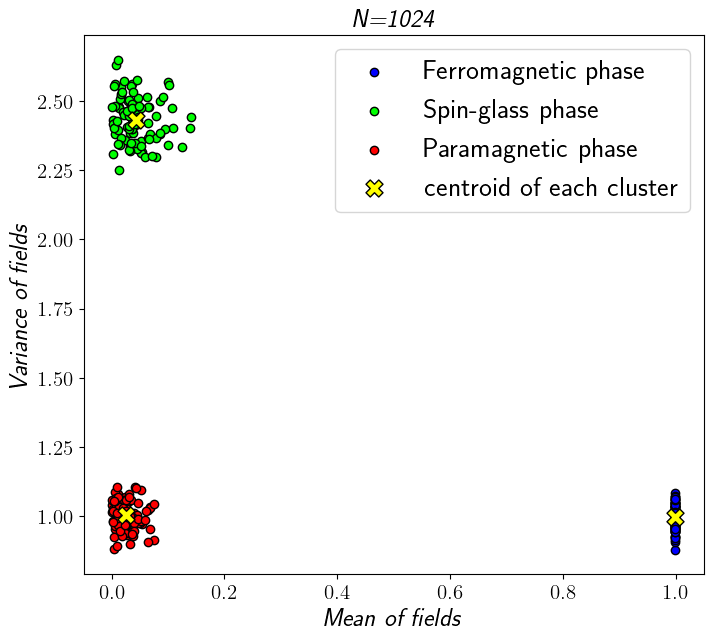

In [5]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,7))
colors = ['blue','lime','red' ]
l_label=['Ferromagnetic phase','Spin-glass phase','Paramagnetic phase','centroid of each cluster']
for i in range(3):
    cluster_points = X[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'{l_label[i]}',edgecolor='black',marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', c='yellow',label=f'{l_label[3]}',edgecolor='black' ,s=150)
plt.xlabel('\\textit{Mean of fields}', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('\\textit{Variance of fields}', fontsize=18)
plt.yticks(fontsize=15)
plt.title('\\textit{N=1024}', fontsize=18)
plt.legend(fontsize="20")
plt.savefig("K-means cluster_dual-2",dpi=100)